# Homework 3
Kyle Schluns & Michael Streyle

## Notebook Setup

In [ ]:
# Load useful libraries
import numpy as np
import pandas as pd

from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_selection import SelectKBest

import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Download data from Kaggle and unzip:

In [ ]:
!cp "/content/drive/MyDrive/Colab Notebooks/E82/kaggle.json" "/root/.kaggle/kaggle.json"
!kaggle competitions download -c csci-e-82-2022
!unzip csci-e-82-2022.zip

mkdir: cannot create directory ‘/root/.kaggle’: File exists
 86% 14.0M/16.3M [00:00<00:00, 39.1MB/s]
100% 16.3M/16.3M [00:00<00:00, 39.6MB/s]
Archive:  csci-e-82-2022.zip
  inflating: sample_solution.csv     
  inflating: test_data.csv           
  inflating: train_data.csv          


## Exploratory Data Analysis

Read in the data and display it.

In [ ]:
train = pd.read_csv("train_data.csv")
train.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,z217,z218,z219,z220,z221,z222,subject,phase,state,output
0,0,0,0,1,-323.106605,2.694366,-1.987520,261.092784,0.013704,0.000100,...,-0.004930,-0.005554,5.246375,-7.534092,3.530736,-0.539045,K,3,C,1
1,0,0,0,1,-376.084691,0.969696,-6.933765,355.311648,0.030292,-0.000153,...,0.022757,0.052506,-3.727741,-2.854443,-0.699268,-0.054074,A,4,C,1
2,0,0,0,0,91.955425,2.621643,-2.581162,51.357206,0.036668,-0.000104,...,-0.086813,-0.101497,-7.510594,19.564182,-17.008130,4.945392,D,3,C,1
3,0,0,0,1,-391.814586,1.866914,-2.510799,382.900317,0.007947,-0.000028,...,0.030856,-0.161398,-6.435819,2.174453,-0.153956,-0.003958,G,2,C,0
4,0,0,0,0,-363.823732,2.951346,-3.726368,330.527539,0.010074,-0.000004,...,-0.017226,-0.016454,-2.581403,3.011932,-1.281361,0.192647,C,2,C,1


Count the number of variables with any missing data. The fact that the table is empty means that there is no missing data in the train data.

In [ ]:
train.isna().sum(axis=0).reset_index().rename(columns={'index':'var',0:'cnt'}).query('cnt > 0')

,var,cnt


The code below shows that there is data imbalance in the target variable `output`, such that 84.5% of the data are class `1` and the other 15.5% are class `0`. 

In [ ]:
train['output'].value_counts()

1    3873
0     711
Name: output, dtype: int64

In [ ]:
train['output'].value_counts()/train['output'].count()

1    0.844895
0    0.155105
Name: output, dtype: float64

For the categorical data, print group-level counts to check for data sparsity and group-level mean of `output` (which conveys how predictive a particular group might be). 

We find that there is only one sparse feature, which occurs for the `state` feature for group "E" since it only has 2 occurrences in the data.

Since the data is imbalanced where 84.5% of observations are class `1`, any mean `output` value that is statistically different from 84.5% will be a predictive feature. We can see that there are significant predictive power in the `subject` feature, and some minor predictive power in the other two features.

In [ ]:
cat_cols = ['subject','phase','state']
for col in cat_cols:
  print(train.groupby(col)['output'].agg(['count','mean']),'\n')

         count      mean
subject                 
A          380  0.971053
B          513  0.859649
C          361  0.756233
D          420  0.938095
F          330  0.778788
G          518  0.492278
H          181  0.861878
I          663  0.962293
K          468  1.000000
L          444  0.912162
M          306  0.709150 

       count      mean
phase                 
1       1215  0.827160
2       1063  0.797742
3       1015  0.871921
4       1291  0.879163 

       count      mean
state                 
A        398  0.864322
B       1502  0.859521
C       2106  0.845204
D        576  0.791667
E          2  1.000000 



Let's split up the numeric columns (`train_num`), the categorical columns (`train_cat`), and the target variable (`train_y`).

In [ ]:
train_num = train.iloc[:,:-4]
train_cat = train.iloc[:,-4:-1]
train_y = train['output']

Now let's apply standard scaling to the numeric data and run PCA. We find the following conclusions:
- The first 20 components convey about 65% of the variance
- The first 100 components convey about 90% of the variance
- The first 200 components convey about 99% of the variance

This means we probably want to use somewhere between 100-200 PCA components for feature selection into a potential model. 

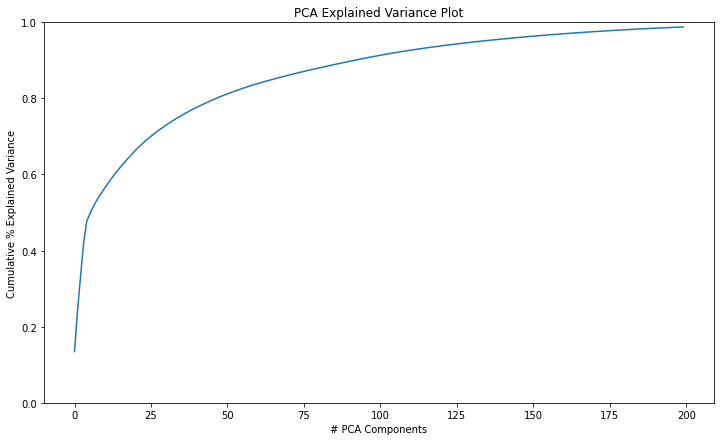

In [ ]:
scaler = StandardScaler()
train_num_scaled = scaler.fit_transform(train_num)

pca_n_components = 200
pca = PCA(n_components=pca_n_components)
train_num_pca = pd.DataFrame(pca.fit_transform(train_num_scaled),columns=[f"pca{i+1}" for i in range(pca_n_components)])

pca_explained_var = pd.Series(pca.explained_variance_ratio_.cumsum()).reset_index()
pca_explained_var.columns = ['n_components','cum_explained_var']

fig = plt.figure(figsize=(12,7))
sns.lineplot(data=pca_explained_var,x='n_components',y='cum_explained_var')
plt.ylim([0,1])
plt.xlabel("# PCA Components")
plt.ylabel("Cumulative % Explained Variance")
plt.title("PCA Explained Variance Plot")
plt.show()

Now let's one-hot encode the categorical data and concatenate it with the 200 PCA numeric columns.

In [ ]:
ohe = OneHotEncoder(drop="first")
train_cat_ohe = ohe.fit_transform(train_cat)
train_cat_ohe = pd.DataFrame(train_cat_ohe.toarray(),columns=ohe.get_feature_names_out())

train_concat = pd.concat([train_num_pca,train_cat_ohe],axis=1)
train_concat.head()

,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8,pca9,pca10,...,subject_K,subject_L,subject_M,phase_2,phase_3,phase_4,state_B,state_C,state_D,state_E
0,-3.032506,-3.062813,-4.572669,-0.838078,6.389029,-1.079410,1.049353,0.846976,-2.456823,-1.736300,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,7.997720,-1.687093,1.703193,-0.580068,-3.193906,-2.280631,1.573460,-2.514034,-0.728222,1.666008,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,-9.404525,1.695259,12.249572,9.263603,14.538742,-1.382768,3.265562,0.838067,-1.688740,-0.896983,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,-0.744583,-5.902031,-2.364589,-6.932070,1.438645,1.851355,3.181267,-7.113462,-0.721635,0.458521,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.051905,-1.039067,-7.116174,-2.271226,7.030159,-0.690243,0.506123,-1.972264,-2.367035,-1.824257,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


Let's use the SelectKBest on all the columns and then apply a conservative threshold to only keep those with p-value < 0.10. This results in selecting 69 columns. Below we display the top 10 of both the most predictive features and the least predictive features. Based on the earlier EDA, it's no surprise that the categorical features are most important.

In [ ]:
f_selector = SelectKBest(k="all")
train_concat_selected = f_selector.fit_transform(train_concat,train_y)

best_k = (f_selector.pvalues_ < 0.1).sum()
f_selector = SelectKBest(k=best_k)
train_concat_selected = f_selector.fit_transform(train_concat,train_y)
train_concat_selected = pd.DataFrame(train_concat_selected,columns=f_selector.get_feature_names_out())

f_selector_col_idx = {col:i for i, col in enumerate(train_concat.columns) if col in train_concat_selected.columns}
f_selector_scores = [{'col':col, 'score':f_selector.scores_[idx], 'pvalue': f_selector.pvalues_[idx]}  for col, idx in f_selector_col_idx.items()]
f_selector_scores = pd.DataFrame(f_selector_scores)
f_selector_scores.sort_values("score",ascending=False).head(10)

,col,score,pvalue
59,subject_G,630.009214,2.227797e-130
61,subject_K,97.680711,8.300224e-23
60,subject_I,82.956959,1.226185e-19
63,subject_M,46.552758,1.008026e-11
2,pca3,33.081708,9.411036e-09
57,subject_D,30.839719,2.960796e-08
3,pca5,30.451125,3.612514e-08
1,pca2,25.368775,4.917160e-07
56,subject_C,23.617124,1.214631e-06
64,phase_2,23.590887,1.231219e-06


In [ ]:
f_selector_scores.sort_values("score",ascending=False).tail(10)

,col,score,pvalue
43,pca136,3.239714,0.071939
7,pca16,3.198478,0.073773
33,pca95,3.152045,0.075898
52,pca170,3.047471,0.080930
28,pca74,3.039145,0.081346
25,pca64,2.988802,0.083910
21,pca50,2.987215,0.083992
13,pca32,2.982329,0.084245
48,pca148,2.817587,0.093305
44,pca141,2.792378,0.094782


Now let's do some further EDA to visualize the predictive power for some of the top features identified by SelectKBest. It's worth restating that anything significantly different from the observed overall probability of class `1` in the `output` variable (84.5%) is likely going to be a predictive feature.

This is pretty easily observed in the two categorical features. For the numeric features `pca3` and `pca5`, you can see that they are weak predictors because only the small and large values of the features have distinctly different `output` values compared to the baseline of 84.5%. It is our hope that if we combine many of these weakly predictive features, that the model could be strong. 

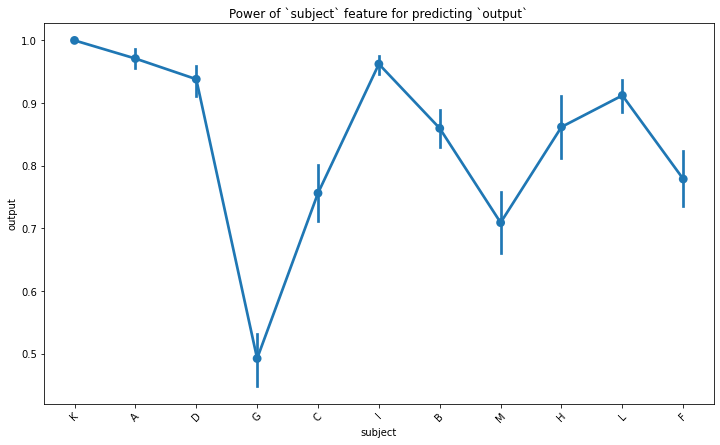

In [ ]:
col = 'subject'
fig = plt.figure(figsize=(12,7))
sns.pointplot(x=train[col],y=train_y)
plt.xticks(rotation=45)
plt.title(f"Power of `{col}` feature for predicting `output`")
plt.show()

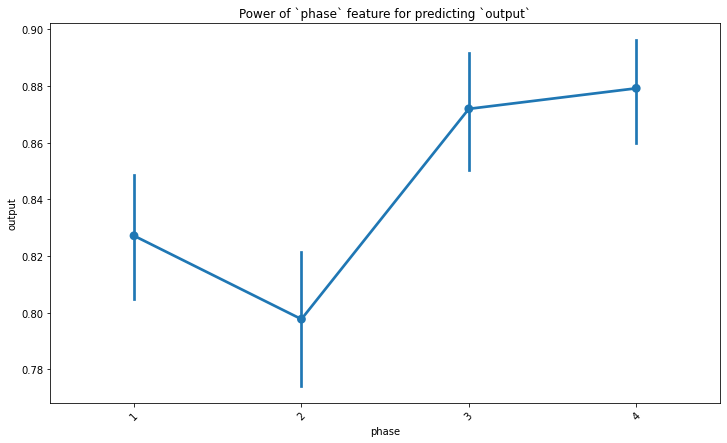

In [ ]:
col = 'phase'
fig = plt.figure(figsize=(12,7))
sns.pointplot(x=train[col],y=train_y)
plt.xticks(rotation=45)
plt.title(f"Power of `{col}` feature for predicting `output`")
plt.show()

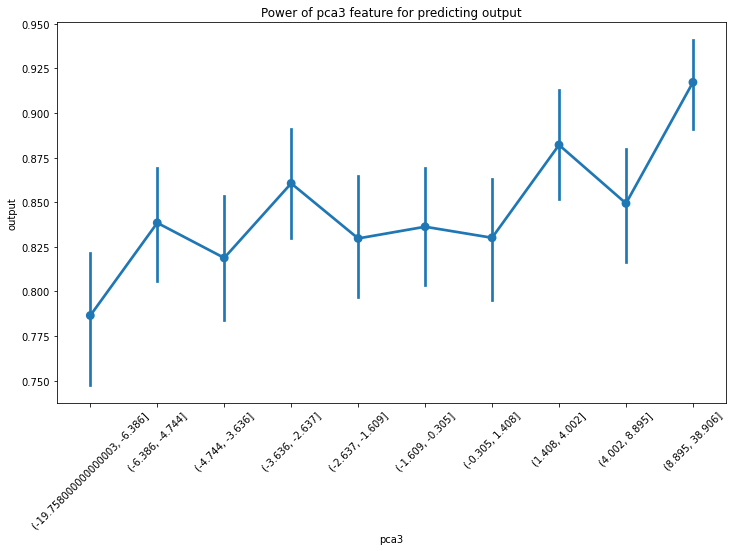

In [ ]:
col = 'pca3'
feature_bin = pd.qcut(train_concat[col],q=10,duplicates="drop")

fig = plt.figure(figsize=(12,7))
sns.pointplot(x=feature_bin,y=train_y)
plt.xticks(rotation=45)
plt.title(f"Power of {col} feature for predicting output")
plt.show()

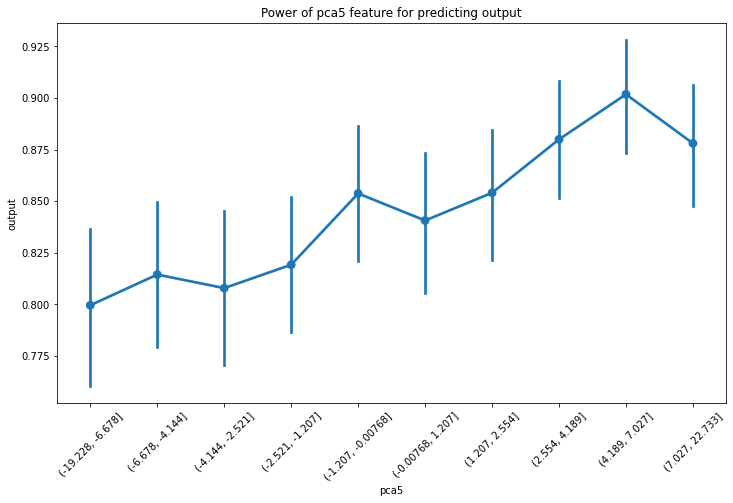

In [ ]:
col = 'pca5'
feature_bin = pd.qcut(train_concat[col],q=10,duplicates="drop")

fig = plt.figure(figsize=(12,7))
sns.pointplot(x=feature_bin,y=train_y)
plt.xticks(rotation=45)
plt.title(f"Power of {col} feature for predicting output")
plt.show()

Now look at the two weakest predictors as determined by SelectKBest: `pca148` and `pca141`. To no surprise, these are even weaker features, but they could be useful when combined with others in a large model.

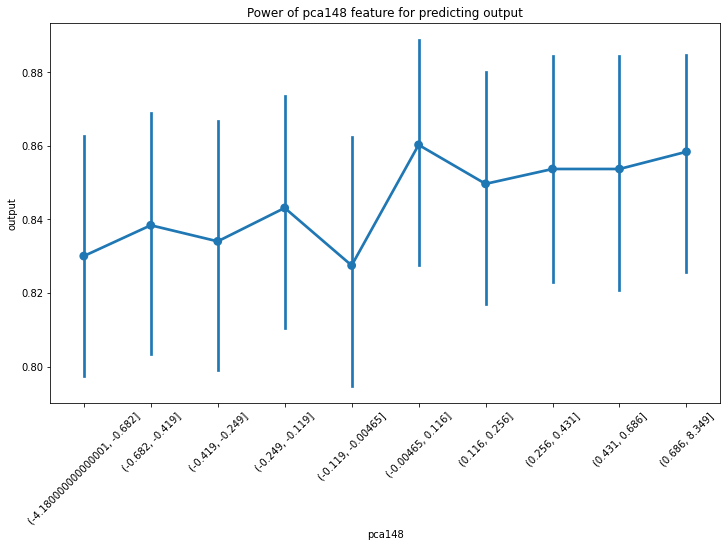

In [ ]:
col = 'pca148'
feature_bin = pd.qcut(train_concat[col],q=10,duplicates="drop")

fig = plt.figure(figsize=(12,7))
sns.pointplot(x=feature_bin,y=train_y)
plt.xticks(rotation=45)
plt.title(f"Power of {col} feature for predicting output")
plt.show()

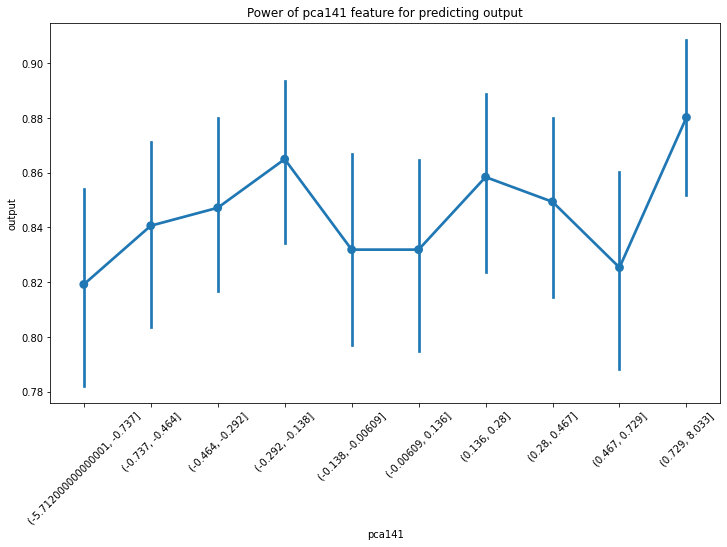

In [ ]:
col = 'pca141'
feature_bin = pd.qcut(train_concat[col],q=10,duplicates="drop")

fig = plt.figure(figsize=(12,7))
sns.pointplot(x=feature_bin,y=train_y)
plt.xticks(rotation=45)
plt.title(f"Power of {col} feature for predicting output")
plt.show()

## Modeling Strategy

Let's use this space to brainstorm ideas for what model frameworks we should attempt:

Kyle
- Random Forest classifier will likely perform best
- Logistic regression would be useful as a baseline model

Michael
- XGboost classifier
- Could test impact of limiting features going into model based on the SelectKBest
- Could test impact of combining SMOTE and random undersampling (as mentioned [here](https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/))
- Utilize UMAP to visualize dimensionality reduction